# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

/home/ddallo/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 52 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 19 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 17 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 16 Dynapse1DevKit serial_number 00000007
[4]:  Bus 1 Device 127 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 124 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [41]:
schip = score = 0
sid = 200
chip = core_e1 = 0
core_e2 = 3
core_i = 1

duration = 2

neuron_ids_E1 = np.arange(11,19)
neuron_ids_E2 = neuron_ids_E1 + neuron_ids_E1.size
neuron_ids_I1 = [2]
neuron_ids_I2 = [1]
# neuron_id_Icommon = 1

# init a network generator
net = network.DynapseNetworkGenerator()

spikegen = net.get_spikegen(schip, score, sid)
neurons_E1 = net.get_neurons(chip, core_e1, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e2, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)
# neuron_Icommon = net.get_neuron(chip, core_i2, neuron_id_Icommon)

net.add_connections_one_to_all(spikegen, neurons_E1, network.SYNAPSE_NMDA, weight=2)
net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_one_to_all(spikegen, neurons_E2, network.SYNAPSE_NMDA, weight=2)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=2)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=8)
# coupling
net.add_connections_all_to_all(neurons_I1, neurons_I2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2, neurons_I1, network.SYNAPSE_GABA_B)
# net.add_connections_all_to_one(neurons_E1, neuron_Icommon, network.SYNAPSE_AMPA)
# net.add_connections_all_to_one(neurons_E2, neuron_Icommon, network.SYNAPSE_AMPA)
# net.add_connections_one_to_all(neuron_Icommon, neurons_E1, network.SYNAPSE_GABA_A)
# net.add_connections_one_to_all(neuron_Icommon, neurons_E2, network.SYNAPSE_GABA_A)
# cheating...
# net.add_connections_one_to_all(neurons_I2, neurons_E1, network.SYNAPSE_AMPA)
# net.add_connections_one_to_all(neurons_I1, neurons_E2, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons_E1, neurons_E2, neurons_I1, neurons_I2)

model.apply_configuration(net.get_config())

poisson_gen = dynapse.get_poisson_spikegen(0, schip, score, sid)

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [289]:
# set params
parameters.set_all_default_params(model)

# try to get each oscillator at 2 Hz
parameters.set_param(model, parameters.AMPA_WEIGHT, (5,40), chip, core_e1)
# parameters.set_param(model, parameters.NMDA_WEIGHT, (5,70), chip, core_e1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,100), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,200), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,80), chip, core_e1)

parameters.set_param(model, parameters.AMPA_WEIGHT, (5,60), chip, core_e2)
# parameters.set_param(model, parameters.NMDA_WEIGHT, (5,120), chip, core_e2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,120), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,200), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,80), chip, core_e2)

parameters.set_param(model, parameters.AMPA_WEIGHT, (5,20), chip, core_i)
# parameters.set_param(model, parameters.AMPA_LEAKAGE, (2,80), chip, core_i)
# parameters.set_param(model, parameters.AMPA_GAIN, (2,80), chip, core_i)

parameters.set_param(model, parameters.GABA_B_WEIGHT, (6,80), chip, core_i)
parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,60), chip, core_i)
# parameters.set_param(model, parameters.GABA_B_GAIN, (4,10), chip, core_i)

19294.0

In [43]:
dynapse.start_graph()
poisson_gen.start()

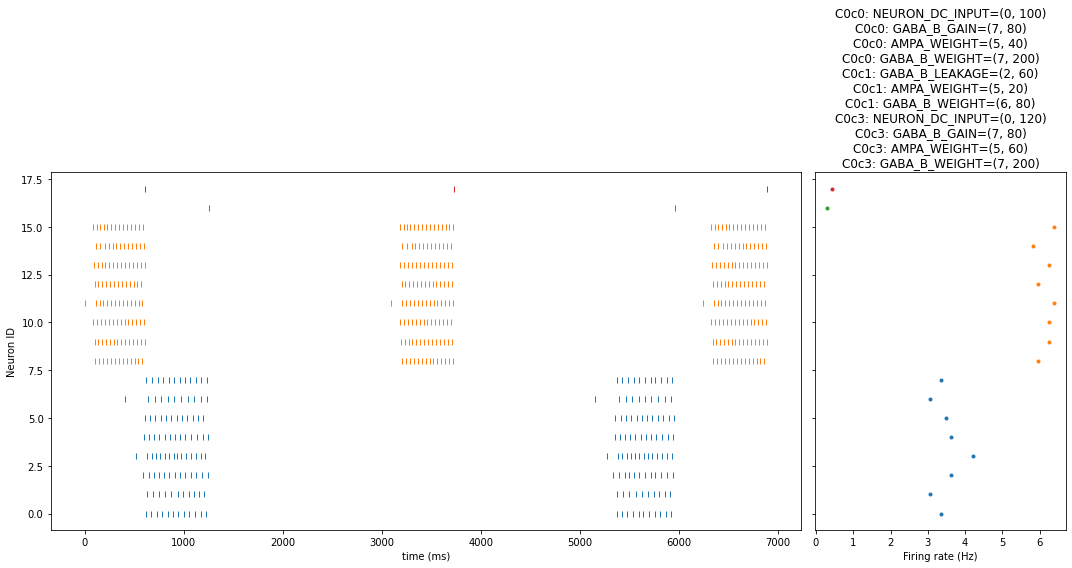

In [290]:
# poisson_gen.start()
spikes = dynapse.run_simulation(10)
# poisson_gen.stop()

# plotting.plot_spikes(dynapse, spikes)
plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,8))

# end_of_pulse_e1 = e1[np.where(np.diff(e1[:,0] / 1000) > 200), 0][0] / 1000
# end_of_pulse_e2 = e2[np.where(np.diff(e2[:,0] / 1000) > 200), 0][0] / 1000
# print(f'Firing rate e1 = {1000 * (len(end_of_pulse_e1) - 1) / (end_of_pulse_e1[-1]-end_of_pulse_e1[0])} Hz')
# print(f'Firing rate e2 = {1000 * (len(end_of_pulse_e2) - 1) / (end_of_pulse_e2[-1]-end_of_pulse_e2[0])} Hz')

### Testing for weird memory bug

In [115]:
default_param_map = parameters.get_default_params().param_map
config = model.get_configuration()

for chip in range(4):
		for core in range(4):
			for param_name, param in config.chips[chip].cores[core].parameter_group.param_map.items():
				if default_param_map[param_name].coarse_value != param.coarse_value or default_param_map[param_name].fine_value != param.fine_value:
					print(f'{param_name}: {(param.coarse_value,param.fine_value)} vs. {(default_param_map[param_name].coarse_value,default_param_map[param_name].fine_value)}')

NPDPII_THR_S_P: (7, 80) vs. (4, 80)
PS_WEIGHT_EXC_F_N: (5, 40) vs. (0, 0)
PS_WEIGHT_EXC_S_N: (5, 50) vs. (0, 0)
PS_WEIGHT_INH_S_N: (7, 200) vs. (0, 0)
PS_WEIGHT_EXC_F_N: (5, 30) vs. (0, 0)
PS_WEIGHT_INH_S_N: (6, 80) vs. (0, 0)
